In [8]:
import torch

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"cuDNN version: {torch.backends.cudnn.version()}")
print(f"CUDA version: {torch.version.cuda}")

CUDA available: True
cuDNN version: 8700
CUDA version: 11.8


Total GPU memory: 4.29 GB
Allocated GPU memory: 3.68 GB
Cached GPU memory: 4.97 GB
Using device: cuda
CUDA out of memory error. Attempting to load model on CPU...
Model loading time: 49.96 seconds


100%|██████████| 20/20 [05:18<00:00, 15.90s/it]


Image generation time: 367.09 seconds
Total GPU memory: 4.29 GB
Allocated GPU memory: 3.68 GB
Cached GPU memory: 11.42 GB
Image saved as output_image.png


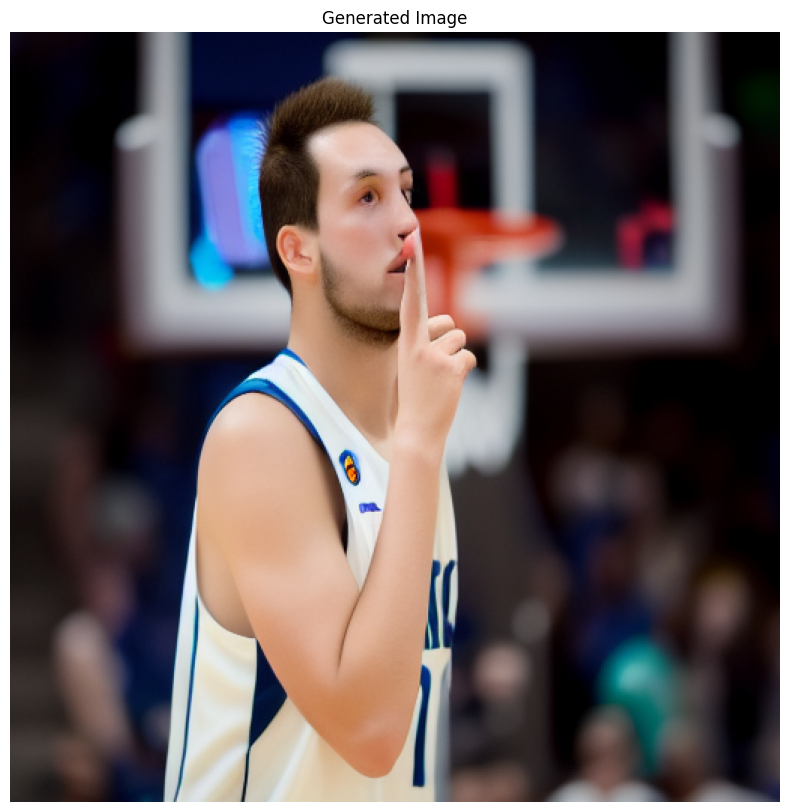

Final GPU memory usage:
Total GPU memory: 4.29 GB
Allocated GPU memory: 3.68 GB
Cached GPU memory: 4.97 GB
Script execution completed.


In [4]:
import model_loader
import pipeline
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
import torch
import torch.cuda.amp as amp
import time
import gc
import matplotlib.pyplot as plt

def print_gpu_memory_usage():
    if torch.cuda.is_available():
        print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        print(f"Allocated GPU memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        print(f"Cached GPU memory: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

def clear_gpu_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        gc.collect()

DEVICE = "cpu"
ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
    clear_gpu_memory()
    print_gpu_memory_usage()
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned-emaonly.ckpt"

start_time = time.time()
try:
    with amp.autocast(dtype=torch.float16):
        models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)
except RuntimeError as e:
    if "CUDA out of memory" in str(e):
        print("CUDA out of memory error. Attempting to load model on CPU...")
        models = model_loader.preload_models_from_standard_weights(model_file, "cpu")
    else:
        raise e
print(f"Model loading time: {time.time() - start_time:.2f} seconds")

prompt = "A white and sexy basketball player with a blue hat, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
uncond_prompt = ""
do_cfg = True
cfg_scale = 8

image_path = "../images/luka.jpg"
input_image = Image.open(image_path).convert('RGB').resize((512, 512))
strength = 0.4

sampler = "ddpm"
num_inference_steps = 50
seed = 42

start_time = time.time()
try:
    with amp.autocast(dtype=torch.float16):
        output_image = pipeline.generate(
            prompt=prompt,
            uncond_prompt=uncond_prompt,
            input_image=input_image,
            strength=strength,
            do_cfg=do_cfg,
            cfg_scale=cfg_scale,
            sampler_name=sampler,
            n_inference_steps=num_inference_steps,
            seed=seed,
            models=models,
            device=DEVICE,
            idle_device="cpu",
            tokenizer=tokenizer,
        )
except RuntimeError as e:
    if "CUDA out of memory" in str(e):
        print("CUDA out of memory error during image generation. Attempting to use CPU...")
        output_image = pipeline.generate(
            prompt=prompt,
            uncond_prompt=uncond_prompt,
            input_image=input_image,
            strength=strength,
            do_cfg=do_cfg,
            cfg_scale=cfg_scale,
            sampler_name=sampler,
            n_inference_steps=num_inference_steps,
            seed=seed,
            models=models,
            device="cpu",
            idle_device="cpu",
            tokenizer=tokenizer,
        )
    else:
        raise e
print(f"Image generation time: {time.time() - start_time:.2f} seconds")

if DEVICE == "cuda":
    print_gpu_memory_usage()

output_image_pil = Image.fromarray(output_image)
output_image_pil.save("output_image.png")
print("Image saved as output_image.png")

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(output_image_pil)
plt.axis('off')
plt.title("Generated Image")
plt.show()

# Cleanup
del models
del output_image
clear_gpu_memory()

if DEVICE == "cuda":
    print("Final GPU memory usage:")
    print_gpu_memory_usage()

print("Script execution completed.")